In [1]:
import numpy as np
from scipy import linalg as la
from os import walk
from scipy.ndimage import imread
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:

def getFaces(path="./faces94"):
    """Traverse the directory specified by 'path' and return an array containing one column vector per subdirectory.
    For the faces94 dataset, this gives an array with just one column for each face in the dataset.
    Each column corresponds to a flattened grayscale image.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg":          # only get jpg images
                 # Load the image, convert it to grayscale, and flatten it into vector.
                faces.append(imread(dirpath+"/"+f).mean(axis=2).ravel())
                break
    # Put all face vectors column-wise into a matrix.
    return np.transpose(faces)

Run the below code, changing "whichFace" to see the different faces in the database

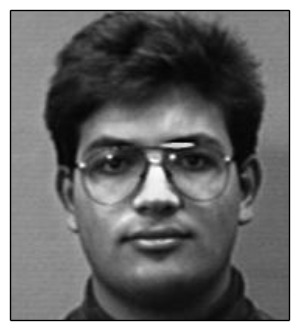

In [3]:
whichFace = 23 #Make sure to only choose values in [0,152]
F = getFaces()

def displayImage(face):
    """Reshape a flattened column from our faces matrix and display it in gray-scale"""
    plt.imshow(face.reshape((200,180)), cmap="gray")
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

displayImage(F[:,whichFace])

In [4]:
class FacialRec(object):
    """
    Facial Recognition class that allows us to import images from a database and find matches to new images
    Attributes:
        F - Collection of faces
        mu - Mean image of the faces
        Fbar
        U
    """
    def __init__(self,path):
        self.initFaces(path)
        self.initMeanImage()
        self.initDifferences()
        self.initEigenfaces()
    def initFaces(self, path):
        """return the faces from the database as column vectors in the matrix"""
        self.F = getFaces(path)
    def initMeanImage(self):
        """find the 'mean' of all the faces"""
        self.mu = np.mean(self.F, axis=1)
    def initDifferences(self):
        """Shift all of the faces by the mean to accentuate only the most distinct characteristics"""
        self.Fbar = self.F - self.mu[:, np.newaxis]
    def initEigenfaces(self):
        """find a basis of eigenfaces using the singular value decomp of Fbar"""
        self.U, S, Vh = la.svd(self.Fbar, full_matrices = False)
    def project(self, A, s=38):
        """project an image onto the subspace spanned by the eigenfaces"""
        return np.dot(self.U[:,:s].T, A)
    def findNearest(self, image, s=38):
        """This function accepts and image and returns the index of the closest image in the database"""
#         Project Fbar, producing a matrix whose columns are f-hat
        f_hat = self.project(self.Fbar, s)
#         Shift 'image' by the mean and project, producing g-hat
        g_hat = self.project(image - self.mu)
#         Finds the closest image in the database
        smallest = float("inf")
        index = 0
        for i in range(f_hat.shape[1]):
            norm = np.linalg.norm(f_hat[:,i]-g_hat)
            if norm < smallest:
                smallest = norm
                index = i
        return index
            
            

The mean of all of the faces in the database


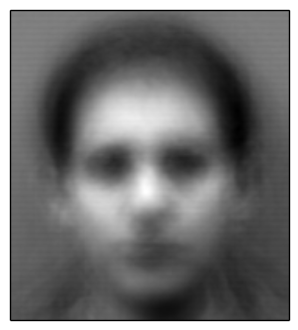

In [5]:
Faces = FacialRec(path="./faces94")

print "The mean of all of the faces in the database"
displayImage(Faces.mu)


Below is an image that has been shifted by the mean to accentuate the distinguishing characteristics

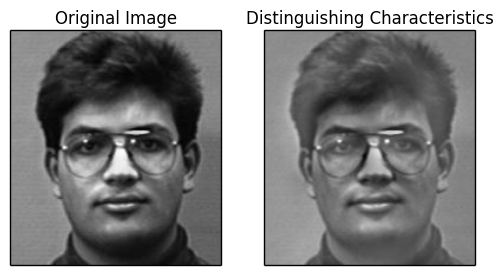

In [6]:
plt.subplot(121)
displayImage(Faces.F[:,whichFace])
plt.title("Original Image")
plt.subplot(122)
plt.title("Distinguishing Characteristics")
displayImage(Faces.Fbar[:,whichFace])


Below we see an 'eigenface'. The eigenface allows us to project our image into a subspace with less data, while maintaining accuracy. Then we can compare faces to build a quick facial recognition sysem

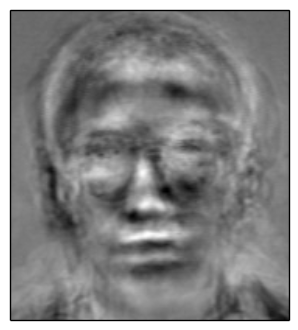

In [7]:
displayImage(Faces.U[:,whichFace])

Projection face with 19 eigenfaces. Notice that this projected face resembles our original image, but it has much less data which allows us to make comparisions very quickly. Accuracy is maintained.

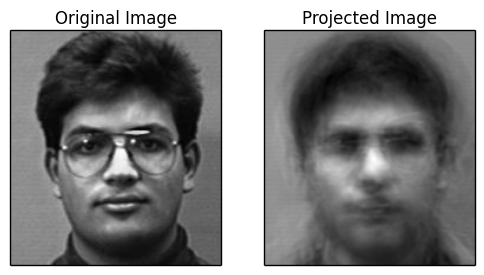

In [8]:
A = Faces.project(Faces.Fbar, 19)
B = np.dot(Faces.U[:,:19],A)
C = B + Faces.mu[:, np.newaxis]

plt.subplot(121)
displayImage(Faces.F[:,whichFace])
plt.title("Original Image")
plt.subplot(122)
plt.title("Projected Image")
displayImage(C[:,whichFace])

We now construction our final Facial recognition system using whichFace again to select a face to find. Now watch as we almost instantly recognize which face we're looking for and print that reconstructed face


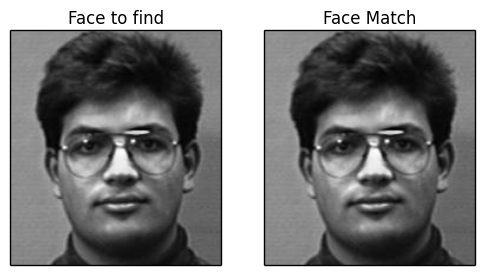

In [11]:
whichFace = whichFace #you can again change this value to see different faces
plt.subplot(121)
displayImage(Faces.F[:,whichFace])
plt.title("Face to find")

plt.subplot(122)
plt.title("Face Match")
displayImage(Faces.F[:,Faces.findNearest(Faces.F[:,whichFace])])


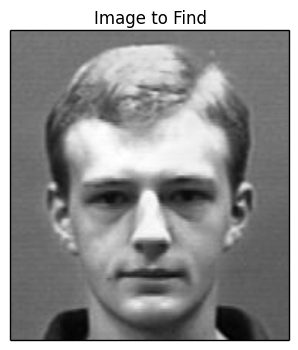

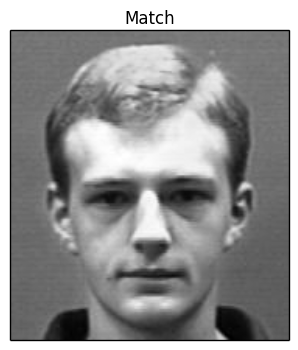

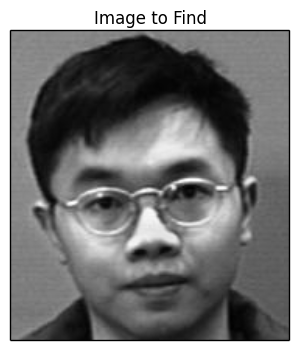

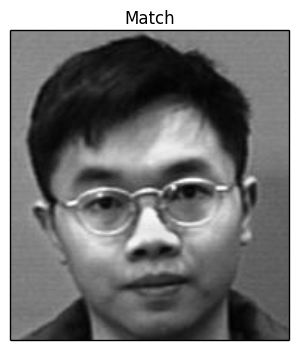

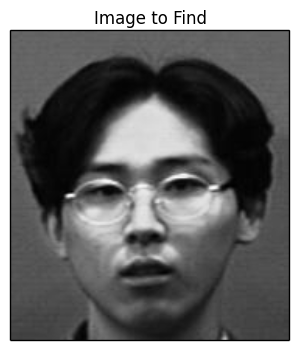

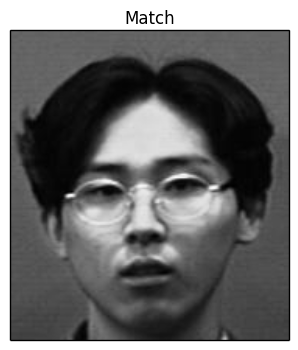

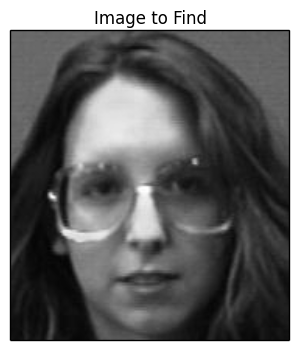

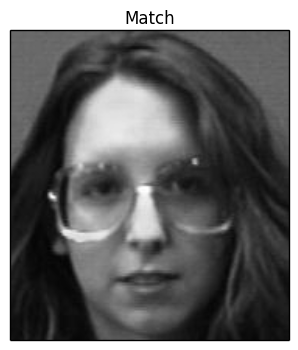

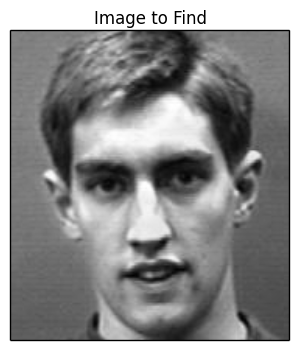

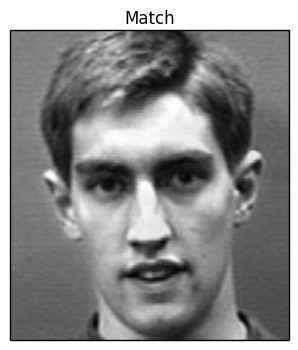

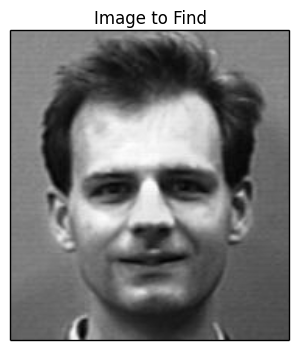

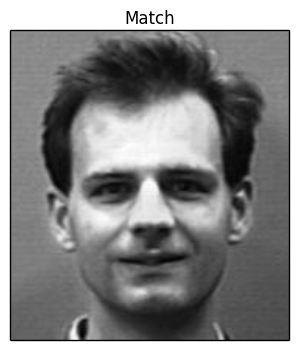

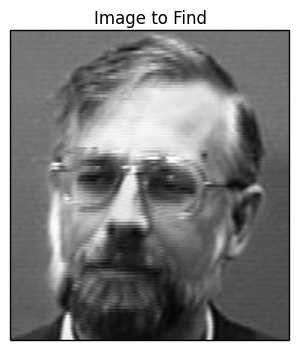

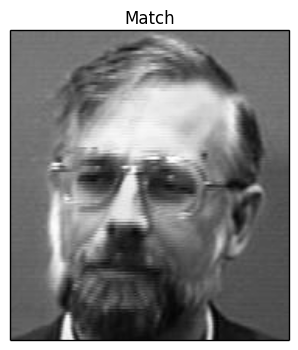

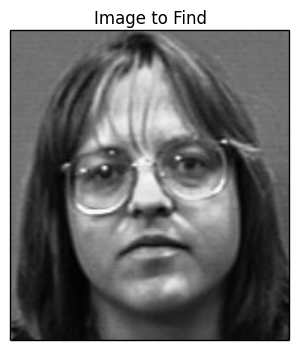

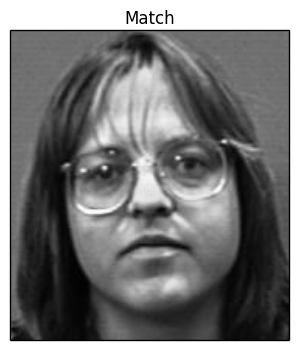

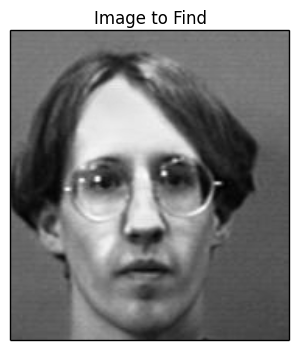

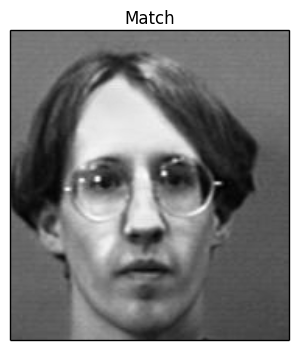

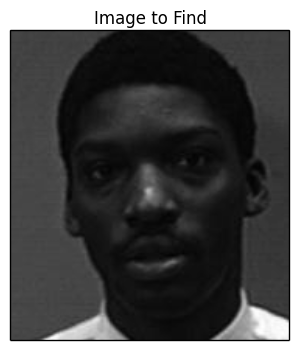

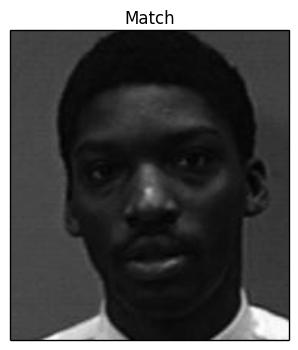

In [10]:

def test_facial_recognition(n_tests):
    """Test facial recognition system on n random images from our database"""
    to_find = []
    found = []
    for i in range(n_tests):
        whichFace = np.random.randint(0,152)
        to_find.append(Faces.F[:,whichFace])
        found.append(Faces.F[:,Faces.findNearest(Faces.F[:,whichFace])])

    for i in range(0,len(to_find)):
        displayImage(to_find[i])
        plt.title("Image to Find")
        plt.show()
    
        plt.title("Match")
        displayImage(found[i])
        plt.show()

        
test_facial_recognition(10)